# Nuance Data

In [101]:
%load_ext autoreload
%autoreload 2
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
import math
    
import mydata
import performance
from F1AUC import PerformanceMeasure, PerformanceOptimisation
from bayes import BayesianRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
db = ["UTKFace", "CelebA", "HAM"]
df = pd.DataFrame()
models = None
length_db = {}

for i in range(len(db)):
    root = f"../../dataset/AAAI 2025/{db[i]}/"
    filepaths = {"EFF": f"{root}evaluation/df_test_EFF_f1.csv", 
                 "RES": f"{root}evaluation/df_test_RES_f1.csv", "VGG": f"{root}evaluation/df_test_VGG_f1.csv"}
    models = list(filepaths.keys())
    
    for k, v in filepaths.items():
        tmp = mydata.uniformdataload(v, True)
        tmp["model"] = k
        tmp["db"] = db[i]
        if k == "EFF":
            length_db[db[i]] = len(tmp)
        df = pd.concat([df, tmp])

In [103]:
df_scores = pd.DataFrame()
df_corr = pd.DataFrame()

for d in range(len(db)):
    for m in range(len(models)):
        pm = PerformanceMeasure(df[(df["db"] == db[d]) & (df["model"] == models[m])], "distance")
        b_start = 10
        b_end = 310
        b_step = 10
        for i in range(b_start, b_end, b_step):
            # batch
            tmp = pm.measure(i)
            tmp["batch size"] = i
            tmp["model"] = models[m]
            tmp["db"] = db[d]
            df_scores = pd.concat([df_scores, tmp])
            # Correlation
            tmp = tmp[["distance", "F1", "ACC"]].corr()
            F1 = tmp.at["distance", "F1"]
            ACC = tmp.at["distance", "ACC"]
            dic = {"F1": F1, "ACC": ACC, "batch": i, "model": models[m], "db": db[d]}
            df_corr = pd.concat([df_corr, pd.DataFrame([dic])])

/home/kuniko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kuniko/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


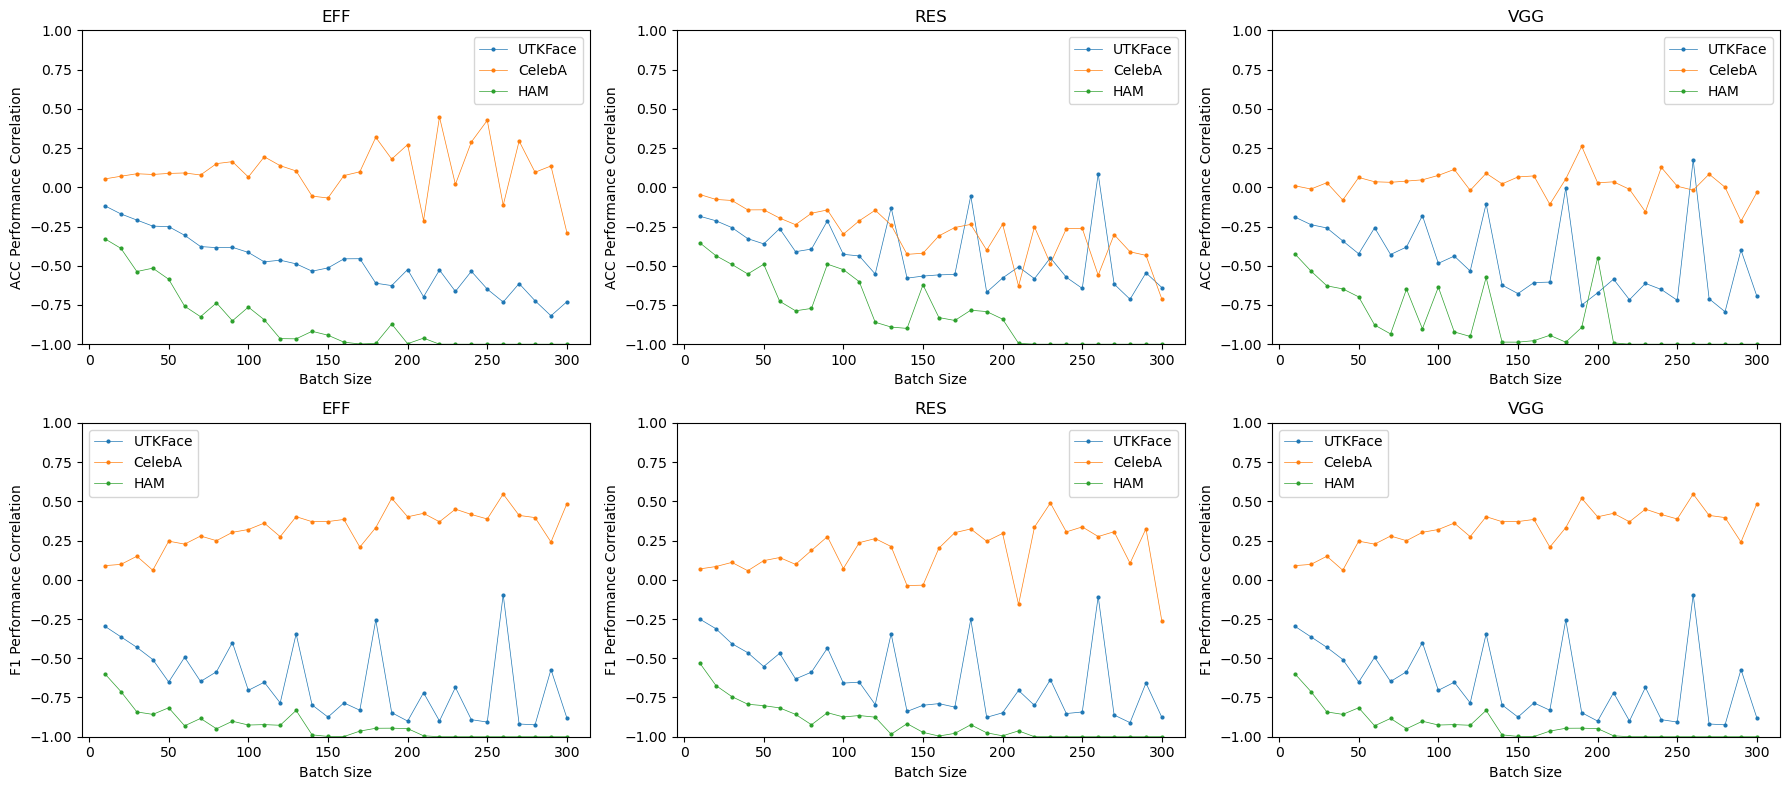

In [104]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8))

for i in range(len(db)):
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "EFF")]
    ax[0, 0].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 0].set_title(f"EFF")
    ax[0, 0].set_xlabel("Batch Size")
    ax[0, 0].set_ylabel("ACC Performance Correlation")
    ax[0, 0].set_ylim(-1, 1)
    ax[0, 0].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "RES")]
    ax[0, 1].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 1].set_title(f"RES")
    ax[0, 1].set_xlabel("Batch Size")
    ax[0, 1].set_ylabel("ACC Performance Correlation")
    ax[0, 1].set_ylim(-1, 1)
    ax[0, 1].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "VGG")]
    ax[0, 2].plot(subset["batch"], subset["ACC"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[0, 2].set_title(f"VGG")
    ax[0, 2].set_xlabel("Batch Size")
    ax[0, 2].set_ylabel("ACC Performance Correlation")
    ax[0, 2].set_ylim(-1, 1)
    ax[0, 2].legend()

    ax[1, 0].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 0].set_title(f"EFF")
    ax[1, 0].set_xlabel("Batch Size")
    ax[1, 0].set_ylabel("F1 Performance Correlation")
    ax[1, 0].set_ylim(-1, 1)
    ax[1, 0].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "RES")]
    ax[1, 1].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 1].set_title(f"RES")
    ax[1, 1].set_xlabel("Batch Size")
    ax[1, 1].set_ylabel("F1 Performance Correlation")
    ax[1, 1].set_ylim(-1, 1)
    ax[1, 1].legend()
    
    subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == "VGG")]
    ax[1, 2].plot(subset["batch"], subset["F1"], marker="o", label=db[i], markersize=2, linewidth=0.5)
    ax[1, 2].set_title(f"VGG")
    ax[1, 2].set_xlabel("Batch Size")
    ax[1, 2].set_ylabel("F1 Performance Correlation")
    ax[1, 2].set_ylim(-1, 1)
    ax[1, 2].legend()

plt.tight_layout()
plt.show()

In [105]:
df_results = pd.DataFrame()
for i in range(len(db)):
    for j in range(len(models)):
        #batch_size = math.ceil(length_db[db[i]] * 0.01)
        batch_size = math.ceil(length_db[db[i]] * 0.01)
        batch_size = math.ceil(batch_size / 10) * 10
        #print(batch_size)
        subset = df_corr[(df_corr["db"] == db[i]) & (df_corr["model"] == models[j]) & (df_corr["batch"] == batch_size)]
        df_results = pd.concat([df_results, subset])

In [106]:
length_db

{'UTKFace': 2348, 'CelebA': 2129, 'HAM': 434}

In [107]:
df_results

,F1,ACC,batch,model,db
0,-0.379221,-0.208784,30,EFF,UTKFace
0,-0.406953,-0.256730,30,RES,UTKFace
0,-0.430473,-0.259256,30,VGG,UTKFace
0,0.243509,0.086175,30,EFF,CelebA
0,0.110709,-0.084043,30,RES,CelebA
0,0.149998,0.029143,30,VGG,CelebA
0,-0.411743,-0.328679,10,EFF,HAM
0,-0.532534,-0.355019,10,RES,HAM
0,-0.599888,-0.425298,10,VGG,HAM


In [108]:
df_results.to_csv(f"../../dataset/AAAI 2025/corr.csv", index=False)